# Oh no, I squished my OTF!

## How to make your images look bad with high NA objectives

Something I learned the hard way during my post-doc is the effect index mismatching can have on images taken with high NA air objectives (in my case a Nikon CFI L Plan EPI CRB 100X 0.85 NA lens). Many[^1] previous[^2] authors[^3] have commented on and analyzed degradation of image quality when the index for which an objective is designed does not match the one in which it is used. Even so, many users of optical microscopes remain unaware of this issue. The problems induced by index mismatch can be summarized as follows (where $n_{obj}$ is the design index and $n_{sample}$ is the mounting index):

1. NA is reduced to the index of the specimen, i.e. $NA = n_{sample}$, when $n_{obj} > n_{sample}$
1. Compression of the image when $n_{obj} < n_{sample}$ and a concomittant reduction in expected axial resolution
3. Increasing spherical aberration as the objective's focus is moved deeper into the sample when $n_{obj} \neq n_{sample}$

To explain the first problem imagine we are imaging a point source radiating spherical waves of light embedded in a medium of index $n_{sample}$ near the interface with a medium of index $n_{obj}$ (c.f. Figure 1). After a certain axial distance the spherical wave encounters the interface and refracts. Appealing to geometrical optical arguments we say that only the bottom hemisphere of light can be captured. The maximum angle of rays that can be captured are rays that propagate along the interface (i.e. at an angle of 90° relative to the interface normal) and these are refracted at an angle [$\theta_c = \arcsin(n_{sample}/n_{obj})$](https://en.wikipedia.org/wiki/Total_internal_reflection#Critical_angle). According to [Snell's law](https://en.wikipedia.org/wiki/Snell%27s_law) and the definition for [NA](https://en.wikipedia.org/wiki/Numerical_aperture) this means that the maximum possible NA for this configuration is $NA = n_{obj} \sin(\theta_c) = n_{sample} \sin(\pi/2) = n_{sample}$

![Figure 1. A point source emitting from a lower index material to a higher index material](TIRF_Diagram.png)
##### Figure 1. A point source emitting from a lower index material to a higher index material

The second problem, when $n_{obj} < n_{sample}$, is trickier and I covered it in some detail in the [supplemental material](http://science.sciencemag.org/content/367/6475/eaaz5357/suppl/DC1) of our [cryo paper](https://science.sciencemag.org/content/367/6475/eaaz5357). Looking at the OTF support in the $k_xk_z$ plane, as shown in Figure 2, we can see that the OTF gets "squished" in the $k_z$ direction. A key insight is that while the lateral resolution is independent of index due to Snell's law, $NA = n_{obj}\sin(\theta_{obj}) = n_{sample}\sin(\theta_{sample})$, the axial resolution is not.[^4] Axial resolution (sometimes termed [depth of field](https://en.wikipedia.org/wiki/Depth_of_field) or depth of focus) for high NA systems has been derived before[^5] and can be modified for differing indices of refraction to be

$$
\Delta z = \frac{\lambda}{n_{sample} - \sqrt{n_{sample}^2 - NA^2}}
$$

and herein lies the observed squishing effect[^6]: as $n_{sample}$ increases relative to $NA$ the denominator decreases and $\Delta z$ increases.

![Figure 2. OTF support for fixed NA and variable index of refraction ($n$), specifically comparing air ($n=1$) to vitreous ice ($n=1.3$)](featured.png)
##### Figure 2. OTF support for fixed NA and variable index of refraction ($n$), specifically comparing air ($n=1$) to vitreous ice ($n=1.3$)

Investigating the third problem will require real math based on the work of Török[^1], Török[^2], and Egner.[^3]

- [^1]: [P. Török, P. Varga, Z. Laczik, G. R. Booker, Electromagnetic diffraction of light focused through a planar interface between materials of mismatched refractive indices: an integral representation. J. Opt. Soc. Am. A, JOSAA. 12, 325–332 (1995).](https://www.osapublishing.org/josaa/abstract.cfm?uri=josaa-12-2-325)
- [^2]: [P. Török, S. J. Hewlett, P. Varga, The role of specimen-induced spherical aberration in confocal microscopy. Journal of Microscopy. 188, 158–172 (1997).](http://onlinelibrary.wiley.com/doi/10.1046/j.1365-2818.1997.2440802.x/abstract)
- [^3]: [A. Egner, S. W. Hell, in Handbook Of Biological Confocal Microscopy (Springer, Boston, MA, 2006; https://link.springer.com/chapter/10.1007/978-0-387-45524-2_20), pp. 404–413.](https://link.springer.com/chapter/10.1007/978-0-387-45524-2_20)
- [^4]: It should be noted that [Fresnel reflections](https://en.wikipedia.org/wiki/Fresnel_equations) at the interface increase with increasing angle such that the apodization function of the pupil rolls off much faster. Thus while the lateral support of the OTF is unchanged its actual shape will be different and will result in lower _effective_ resolution at lower signal-to-noise ratios.
- [^5]: [C. J. R. Sheppard, Depth of field in optical microscopy. Journal of Microscopy. 149, 73–75 (1988).](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1365-2818.1988.tb04563.x)
- [^6]: Squishing in frequency which is expansion in real space.

## Focal plane displacement in mismatched media, a Vectorial Calculation

I'll be following the notation of Egner[^3]. Equation 9 gives the vectorial point spread function in terms of three diffraction integrals. Note that for on axis light ($x=0$ and $y=0$) the integrands of $I_1(\vec{r})$ and  $I_2(\vec{r})$ are $0$ and $I_0(\vec{r})$ reduces to

$$
I_0(z) = \int_0^\alpha \sqrt{\cos(\theta_1)}\sin(\theta_1)(\tau_s+\tau_p \cos(\theta_2))\exp(ik(\Phi(NFP)+n_2z\cos(\theta_2)))d\theta_1
$$

Where

$$
\Phi(NFP) = -NFP(n_1\cos\theta_1-n_2\cos\theta_2)
$$

$k$ is the wavenumber of the light rays _in vacuo_, i.e. $k = 2\pi/\lambda$. $\alpha$ is the aperature semiangle of the lens, i.e. $\text{NA}=n_1 \sin\alpha$. Note that $n_1 = n_{obj}$ and $n_2 = n_{sample}$.

We can now implement thes functions in Python.

In [1]:
%pylab inline
import scipy.integrate
import scipy.optimize

import seaborn as sns

sns.set()

Populating the interactive namespace from numpy and matplotlib


In [2]:
def complex_quadrature(func, a, b, **kwargs):
    """scipy.integrate.quad doesn't deal with complex numbers, so this hack does"""
    def real_func(x):
        return real(func(x))
    def imag_func(x):
        return imag(func(x))
    real_integral = scipy.integrate.quad(real_func, a, b, **kwargs)
    imag_integral = scipy.integrate.quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])


In [3]:
@vectorize
def i0(z, NFP, n1, n2, NA, wl):
    """This calculates e-field amplitude _relative to_ NFP, only along the z axis with x, y = 0, 0"""
    theta_max = arcsin(NA / n1)
    
    def integrand(theta1):
        sin_t1 = sin(theta1)
        theta2 = arcsin(n1 * sin_t1 / n2)
        sin_t2 = sin(theta2)
        cos_t1 = cos(theta1)
        cos_t2 = cos(theta2)
        ts = 2 * sin_t2 * cos_t1 / sin(theta1 + theta2)
        tp = ts / cos(theta1 - theta2)
        
        k = 2 * pi / wl
        phi = -NFP * (n1 * cos_t1 - n2 * cos_t2)
        # make sure i is complex
        i = exp(1j * k * (phi + n2 * z * cos_t2))
        i *= sqrt(cos_t1) * sin_t1 * (ts + tp * cos_t2)
        return i
        
    return complex_quadrature(integrand, 0, theta_max)[0]

Text(0.5, 1.0, 'Computation Test, Oil Objective')

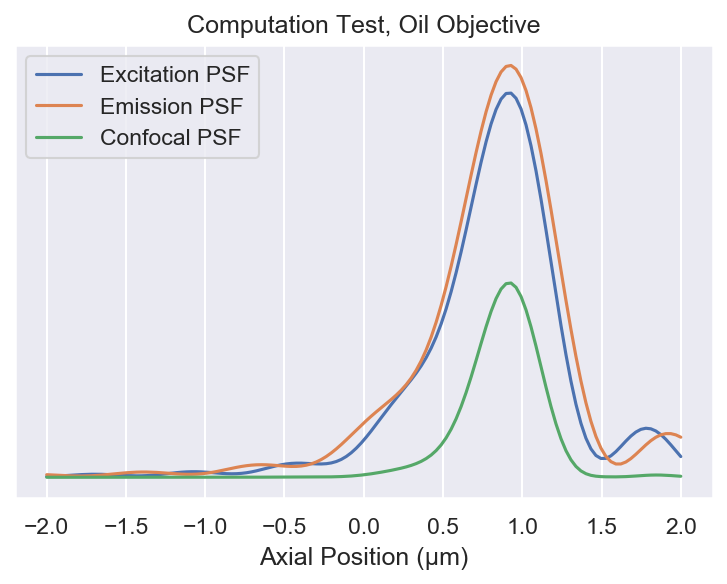

In [4]:
# a short test to see if the calculation works
# using the example from Egner and Hell
# A 1.518 oil objective 1.47 NA
z = np.linspace(-2, 2, 128)
a_exc = i0(z, -15, 1.518, 1.47, 1.33, 0.514)
a_em = i0(z, -15, 1.518, 1.47, 1.33, 0.59)

fig, ax = plt.subplots(dpi=150)
ax.plot(z, abs(a_exc)**2, label="Excitation PSF")
ax.plot(z, abs(a_em)**2, label="Emission PSF")
ax.plot(z, abs(a_exc)**2 * abs(a_em)**2, label="Confocal PSF")
ax.legend()
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_xlabel("Axial Position (µm)")
ax.set_title("Computation Test, Oil Objective")

In [5]:
# we need an esimate of the focal shift in order to reduce computation time
def otf_ratio(n1, n2, NA):
    """The OTF ratio as calculated from the geometrical proof"""
    def func(n):
        # fmax takes care of limiting NA
        return n - sqrt(np.fmax(0, n**2 - NA**2))
    return func(n1) / func(n2)

In [6]:
def _find_afp(NFP, n1, n2, NA, wl_ex, wl_em=None, *, res=32, width=5, ax=None):
    """Find the _apparent_ focal position based on the nominal focal position"""
    
    # if no emission wavelength is given, then calculate the widefield PSF
    if wl_em is None:
        def i0_min(z):
            return -abs(i0(z, NFP, n1, n2, NA, wl_ex))**2
    # otherwise calculate the confocal PSF
    else:
        def i0_min(z):
            toreturn = -abs(i0(z, NFP, n1, n2, NA, wl_ex))**2 
            return toreturn * abs(i0(z, NFP, n1, n2, NA, wl_em))**2
        
    # calculate the approximate focal shift, so the optimization is close to the optimum
    focal_shift = otf_ratio(n1, n2, NA)
    
    # make a rough low res estimate relative to the estimated focal shift
    low_res_z = np.linspace(-width, width, res) + NFP * (focal_shift - 1)
    low_res_a = -i0_min(low_res_z)
    low_res_max_idx = low_res_a.argmax()
    
    # optimize to find the proper location of the optimum
    high_res_max = scipy.optimize.minimize_scalar(i0_min, bounds=(low_res_z[low_res_max_idx - 1], low_res_z[low_res_max_idx + 1]), method='bounded', options=dict(xatol=1e-10))
    
    # looks like we failed to find a maximum
    if not high_res_max.success:
        raise RuntimeError(high_res_max.message)
    
    # make a plot
    if ax is not None:
        ax.plot(low_res_z, low_res_a)
        ax.axvline(high_res_max.x, c="r")
    
    
    max_intensity = -high_res_max.fun
    
    # return the shifted AFP
    return high_res_max.x + NFP, max_intensity


def find_afp(NFP, *args, **kwargs):
    """A simple version to vectorize over z, for convenience"""
    try:
        return np.array([_find_afp(z, *args, **kwargs) for z in NFP])
    except TypeError:
        return _find_afp(NFP, *args, **kwargs)

### Testing

On page 409 of Egner[^3] there are some example calculations that we can repeat to test the validity of the calculations.

/Users/david/miniconda3/envs/sandbox/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


[        inf  2.2220463   0.62956575  1.5641702   1.51523215 -0.91086836
 -2.9878027   2.47268137]
[ 0.         -2.05250791  2.91190777  2.94368608  1.49427111  6.83299954
 14.99787706 39.09604286]


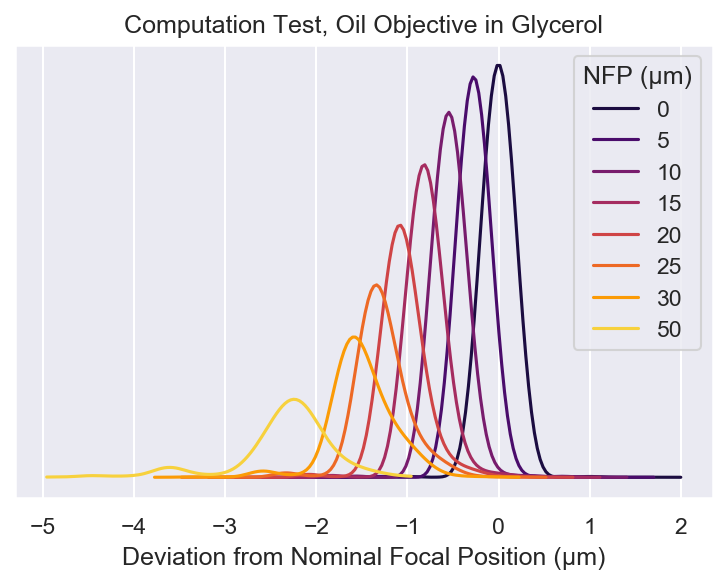

In [7]:
nfps = (0, 5, 10, 15, 20, 25, 30, 50)
with sns.color_palette("inferno", len(nfps)):
    # our confocal calculations
    fig, ax = plt.subplots(dpi=150)
     
    glycerol_cf = find_afp(
        nfps,
        1.518, 1.473, 1.3, 0.514, 0.59,
        res=128, width=2, ax=ax
    )

    # values taken from table 20.1 of Egner and Hell
    glycerol_lit = np.array((
        (0, -0.28, -0.55, -0.83, -1.1, -1.33, -1.54, -2.30),
        (1, 0.95, 0.91, 0.78, 0.62, 0.5, 0.4, 0.31)
    )).T

    # percent differences between our calculations and theirs for focal shift
    print((glycerol_lit[:, 0] - (glycerol_cf[:, 0] - (0, 5, 10, 15, 20, 25, 30, 50))) / glycerol_lit[:, 0] * 100)

    # percent differences between our calculations and theirs for peak intensity
    print((glycerol_lit[:, 1] - glycerol_cf[:, 1] / glycerol_cf[:, 1].max()) / glycerol_lit[:, 1] * 100)

    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_xlabel("Deviation from Nominal Focal Position (µm)")
    for line in ax.get_lines():
        if len(line.get_data()[0]) == 2:
            line.remove()

    ax.set_title("Computation Test, Oil Objective in Glycerol")
    ax.legend(nfps, title="NFP (µm)")

/Users/david/miniconda3/envs/sandbox/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


[        inf -3.89876815 -1.16698752  0.24182932  1.60682485  2.02297875
  3.0281091   5.03027355]
[ 0.         48.28097585 59.70939519 65.5089603  70.36385208 72.25077729
 75.80157613 81.9156686 ]


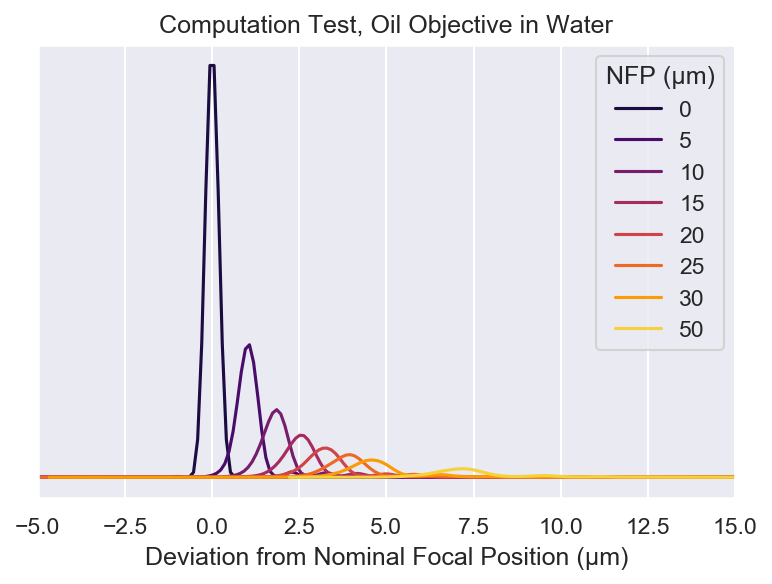

In [8]:
nfps = (0, 5, 10, 15, 20, 25, 30, 50)
with sns.color_palette("inferno", len(nfps)):
    # our confocal calculations
    fig, ax = plt.subplots(dpi=150)

    water_cf = find_afp(
        nfps,
        1.33, 1.473, 1.3, 0.514, 0.59,
        res=256, width=15, ax=ax
    )

    # values taken from table 20.1 of Egner and Hell
    water_lit = np.array((
        (0, -1.0, -1.83, -2.57, -3.3, -4.02, -4.72, -7.57),
        (1, 0.60, 0.39, 0.285, 0.23, 0.19, 0.166, 0.11)
    )).T

    # percent differences between our calculations and theirs for focal shift
    print((water_lit[:, 0] + (water_cf[:, 0] - (0, 5, 10, 15, 20, 25, 30, 50))) / water_lit[:, 0] * 100)

    # percent differences between our calculations and theirs for peak intensity
    print((water_lit[:, 1] - water_cf[:, 1] / water_cf[:, 1].max()) / water_lit[:, 1] * 100)

    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_xlabel("Deviation from Nominal Focal Position (µm)")
    for line in ax.get_lines():
        if len(line.get_data()[0]) == 2:
            line.remove()

    ax.set_xlim(-5, 15)

    ax.set_title("Computation Test, Oil Objective in Water")
    ax.legend(nfps, title="NFP (µm)")

Our simulations match the reported focal length shift to a few percent. There is larger error between the our intensity and theirs

# Simulations for the Cryo-scope

Here the objective is an air objective and the medium is vitreous ice so $n_1=1$ and $n_2=1.3$ and $NA=0.85$

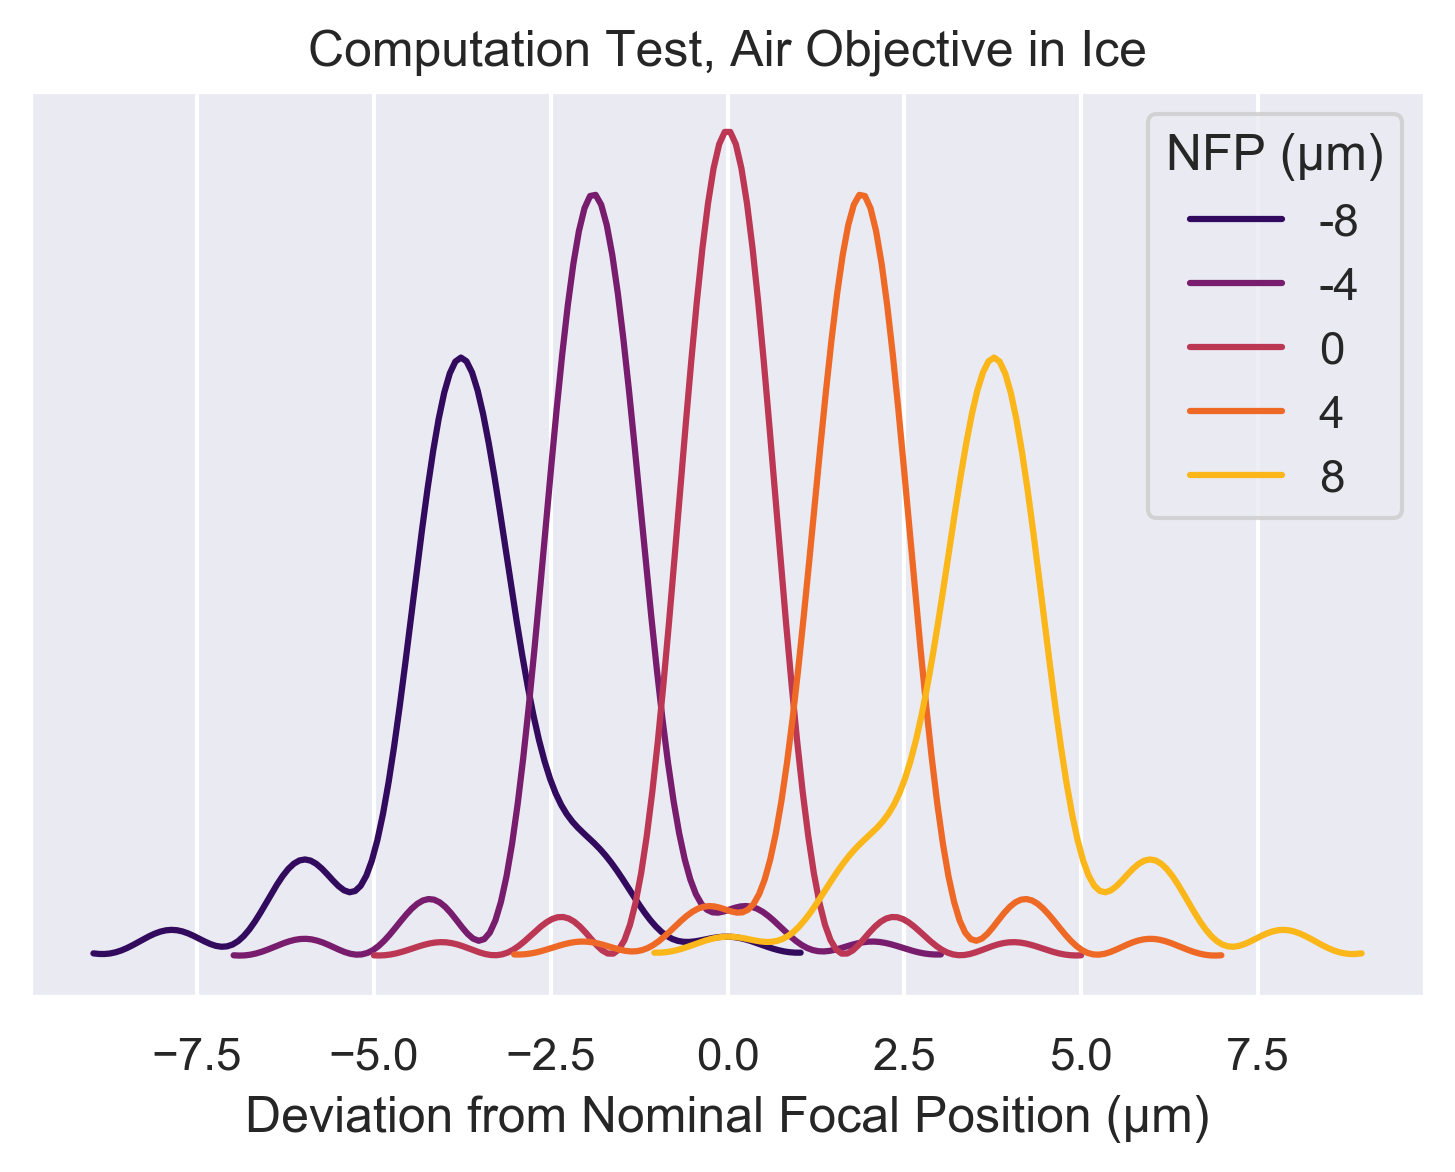

In [9]:
nfps = (-8, -4, 0, 4, 8)
with sns.color_palette("inferno", len(nfps)):
    fig, ax = plt.subplots(dpi=300)
    
    find_afp(nfps, 1.0, 1.3, 0.85, 0.52, res=128, ax=ax)

    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_xlabel("Deviation from Nominal Focal Position (µm)")
    for line in ax.get_lines():
        if len(line.get_data()[0]) == 2:
            line.remove()

    ax.set_title("Computation Test, Air Objective in Ice")
    ax.legend(nfps, title="NFP (µm)")

Clearly, spherical aberrations start to become bad when you're more than 10 µm from the best focal position (and this effect is worse the larger the mismatch between refractive indices).

One question we can ask is: how well does our geometric argument fare against the more complex vectorial calculation? We'll calculate the actual focal position with the complex calculation for multiple nominal focal positions and compare the to the simpler calculation to see the size of the deviation.

In [10]:
# make some NFPs in µm
NFP = np.linspace(0,8)

# calculate the AFPs
AFP = find_afp(NFP, 1.0, 1.3, 0.85, 0.52)

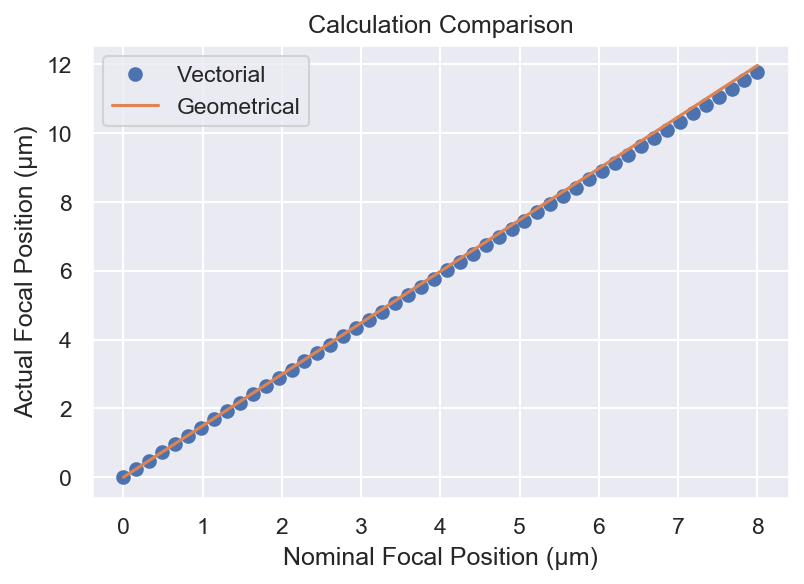

In [11]:
# geometrical stretch
geom_m = otf_ratio(1.0, 1.3, 0.85)

fig, ax = plt.subplots(dpi=150)
ax.plot(NFP, AFP[:, 0], "o", label="Vectorial")
ax.plot(NFP, NFP * geom_m, label="Geometrical")
ax.set_ylabel("Actual Focal Position (µm)")
ax.set_xlabel("Nominal Focal Position (µm)")
ax.set_title("Calculation Comparison")
ax.legend()

Text(0.5, 1.0, 'Difference between Vectorial and Geometrical Calculations')

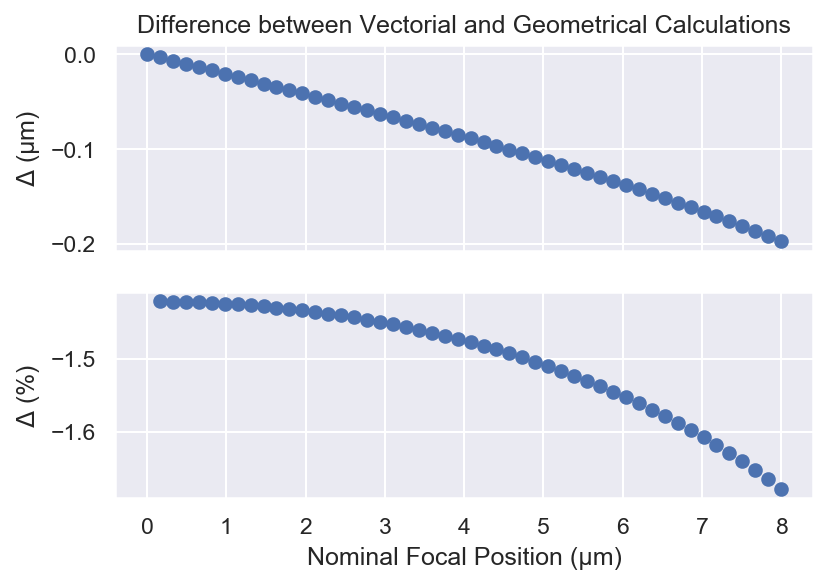

In [12]:
# geometrical stretch
geom_m = otf_ratio(1.0, 1.3, 0.85)

fig, (ax1, ax2) = plt.subplots(2, dpi=150, sharex=True)
ax1.plot(NFP, AFP[:, 0] - NFP * geom_m, "o")
ax2.plot(NFP[1:], 100*((AFP[:, 0] - NFP * geom_m)/AFP[:, 0])[1:], "o")
ax1.set_ylabel("$\Delta$ (µm)")
ax2.set_ylabel("$\Delta$ (%)")
ax2.set_xlabel("Nominal Focal Position (µm)")
ax1.set_title("Difference between Vectorial and Geometrical Calculations")

In [13]:
slope_ratio = (AFP[1:, 0] / NFP[1:]).mean() / geom_m
print(f"The ratio between the complex slope and the simple slope is {slope_ratio:.0%}")

The ratio between the complex slope and the simple slope is 99%


At least as far as focal position is concerned the simple calculation is more than adequate over short distances.

In [14]:
otf_ratio(1, 1.333, 0.95)

1.7283961664318024